In [1]:
import pandas as pd
import operator
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, balanced_accuracy_score
pd.set_option('max_colwidth', 60)

<br>

In [2]:
if True:
    for file in [i[:-4] for i in os.listdir("../aux/") if i[-4:]==".txt"]:
        ! sed 's/"//g' ../aux/{file}.txt > ../aux/processed/{file}

! sed 's/"//g' ../model/model_conditions.txt > model_conditions
! sed 's/"//g' ../model/model_pred.txt > model_pred

In [3]:
train         = pd.read_csv('../data/model/train.csv')
test          = pd.read_csv('../data/model/test.csv')
dataset       = pd.read_csv('../data/model/dataset.csv',index_col=0)
list_cols     = train.columns[:-1].to_list()
dict_data_id  = {row[list_cols].values.tostring():index for index, row in dataset.iterrows()}
list_original = np.array([dict_data_id.get(i_row[list_cols].values.tostring(), 'new') for i_index, i_row in train.iterrows()])

In [4]:
ops = {'<=':operator.le, '>=':operator.ge, '<':operator.lt, '>':operator.gt} 

<br>

In [5]:
def condition_splitter(in_string):
    for condition in ['<=', '>=', '<', '>']:
        condition_split = in_string.split(condition)
        if len(condition_split) == 2:
            return([condition_split, condition])

In [6]:
def get_pred(in_row, file_loc="", file_n=""):
    r_conditions, r_pred = [open(file_loc+file_type+file_n, 'r').read().split("\n") for file_type in ['model_conditions', "model_pred"]]
    for i, rule in enumerate(r_conditions[:-2]):
        cat = True
        for x in list(rule.replace('.p' ,'-p').replace('.a' ,'-a').split(' & ')):
            condition = condition_splitter(x)+[r_pred[i]]
            if ops[condition[1]](in_row.loc[condition[0][0]], np.float(condition[0][1])):
                cat = cat & True
            else:
                cat = cat & False
        if cat: 
            return(int(condition[2]))
    return(int(r_pred[-2]))

<br>

In [7]:
confusion_matrix(y_true=train.label, y_pred=train.apply(lambda row: get_pred(row), axis=1))

array([[43,  8,  7, 10],
       [ 7, 38, 17,  4],
       [ 0, 12, 48, 12],
       [ 0,  0,  3, 64]])

In [8]:
confusion_matrix(y_true=test.label, y_pred=test.apply(lambda row: get_pred(row), axis=1))

array([[9, 3, 2, 3],
       [3, 5, 4, 1],
       [0, 0, 5, 0],
       [0, 0, 0, 4]])

<br>

______

In [9]:
df_testing = pd.DataFrame(index=range(100), columns=['#q']+["{}_{}".format(i, j) for i in range(1,5) for j in train.columns[train.columns!='label'].to_list()])

In [10]:
for i, j, l in [("test", test, balanced_accuracy_score),("train",train, accuracy_score), ('train_adj', train.loc[list_original!="new"], balanced_accuracy_score)]: 
    df_testing.loc[:,"accuracy_"+i] = df_testing.reset_index()["index"].apply(lambda file_row: \
    l(y_true=j.label, y_pred=j.apply(lambda row: get_pred(row, "../aux/processed/", "-{}".format(file_row)), axis=1)))
    
for i, j in [("test", test), ('train_adj', train.loc[list_original!="new"])]:
    for l in ['micro', 'macro', 'weighted']:
        df_testing.loc[:,"f1_{}_{}".format(i,l)] = df_testing.reset_index()["index"].apply(lambda file_row: \
        f1_score(y_true=j.label, y_pred=j.apply(lambda row: get_pred(row, "../aux/processed/", "-{}".format(file_row)), axis=1), average=l))


for file_n, row in df_testing.iterrows():
        r_conditions, r_pred = [open("../aux/processed/{}-{}".format(file_type,file_n), 'r').read().split("\n")[:-1] for file_type in ['model_conditions', "model_pred"]]
        df_testing.loc[file_n,"#q"]=len(r_pred)
        for i, rule in enumerate(r_conditions[:-1]):
            for x in list(rule.replace('.p' ,'-p').replace('.a' ,'-a').split(' & ')):
                condition = condition_splitter(x)+[r_pred[i]]                        # e.g., [['NIIP-pc_gdp', '-62.25'], '<=', '4']
                df_testing.loc[file_n,"{}_{}".format(condition[-1],condition[0][0])] = condition[0][1]

In [11]:
df_testing.head()

#q 1_PC_CA-avg_3y 1_REER-pch_3y 1_X_GS_share_M-pch_5y 1_FSL-pch  \
0   5            NaN           NaN                -6.505       NaN   
1   5            NaN           NaN                 -9.47       NaN   
2   4            NaN           NaN                -4.625       NaN   
3   5            NaN           NaN                 -2.98       NaN   
4   4            NaN           NaN                -9.325       NaN   

  1_GD-pc_gdp 1_HPI-pch 1_NIIP-pc_gdp 1_ULC-pch_3y 1_ACT-pch_3y  ...  \
0         NaN       NaN       -69.274          NaN          NaN  ...   
1         NaN       NaN           NaN          NaN          NaN  ...   
2         NaN       NaN       -54.993          NaN          NaN  ...   
3         NaN       NaN       -66.126          NaN          NaN  ...   
4         NaN       NaN           NaN          NaN          NaN  ...   

  4_UR-avg_3y accuracy_test accuracy_train accuracy_train_adj f1_test_micro  \
0         NaN      0.698586       0.725275           0.683861      0.666667   
1         NaN      0.733880       0.728938           0.685445      0.666667   
2         NaN      0.694287       0.728938           0.657014      0.589744   
3         NaN      0.714649       0.725275           0.664008      0.641026   
4         NaN      0.729355       0.699634           0.664857      0.666667   

  f1_test_macro f1_test_weighted f1_train_adj_micro f1_train_adj_macro  \
0      0.697423         0.667741           0.677632           0.657039   
1      0.714191         0.663027           0.684211           0.671213   
2      0.664927         0.582258           0.638158           0.637966   
3      0.704384         0.636801           0.664474           0.652622   
4      0.708457         0.659346           0.631579           0.644007   

  f1_train_adj_weighted  
0              0.682580  
1              0.687000  
2              0.639929  
3              0.667566  
4              0.635233  

[5 rows x 66 columns]

In [12]:
int_model=df_testing.index[df_testing.accuracy_train_adj==df_testing.accuracy_train_adj.max()][0]
print("Our model is the number {}.".format(int_model))

Our model is the number 32.


In [28]:
df_testing.loc[[int_model]]

#q 1_PC_CA-avg_3y 1_REER-pch_3y 1_X_GS_share_M-pch_5y 1_FSL-pch  \
32   5            NaN           NaN                   NaN       NaN   

   1_GD-pc_gdp 1_HPI-pch 1_NIIP-pc_gdp 1_ULC-pch_3y 1_ACT-pch_3y  ...  \
32         NaN       NaN           NaN          NaN          NaN  ...   

   4_UR-avg_3y accuracy_test accuracy_train accuracy_train_adj f1_test_micro  \
32         NaN      0.758767       0.813187           0.768778      0.717949   

   f1_test_macro f1_test_weighted f1_train_adj_micro f1_train_adj_macro  \
32      0.737401         0.707381           0.763158           0.739424   

   f1_train_adj_weighted  
32               0.76063  

[1 rows x 66 columns]

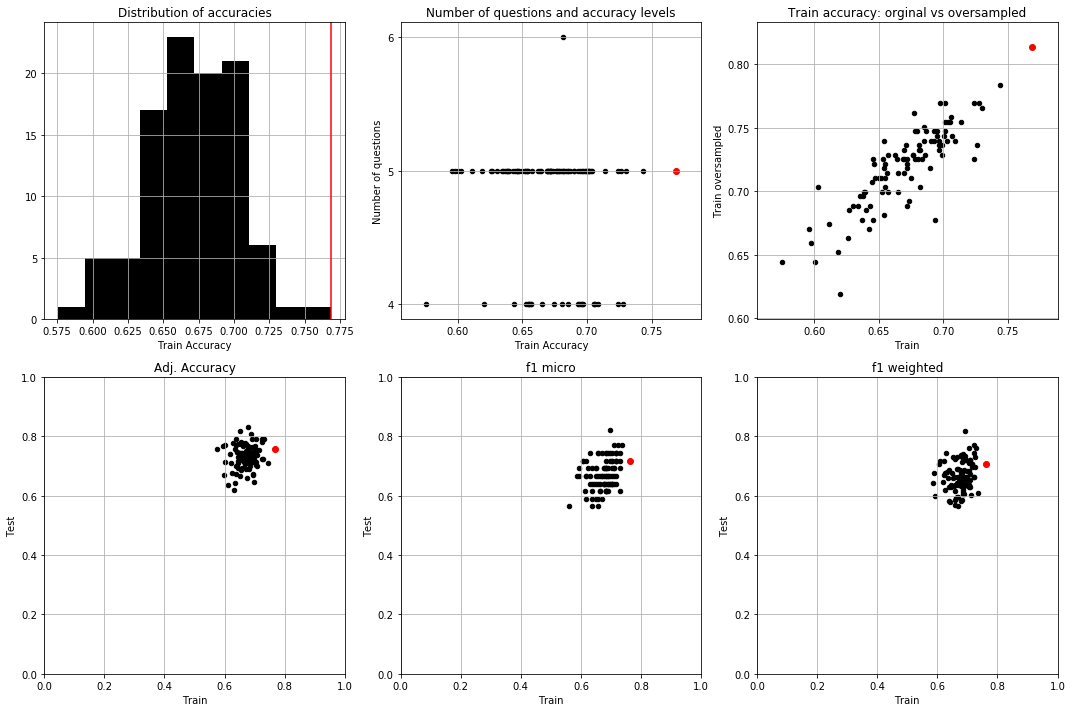

In [13]:
f, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10)); axes=axes.flatten()
df_testing.accuracy_train_adj.hist(ax=axes[0],color='k')
axes[0].set_title("Distribution of accuracies"); axes[0].set_xlabel('Train Accuracy')
df_testing.plot.scatter("accuracy_train_adj", "#q", color="k",grid=True, ax=axes[1])
axes[1].set_title("Number of questions and accuracy levels"); axes[1].set_xlabel('Train Accuracy'); axes[1].set_ylabel('Number of questions'); axes[1].set_yticks(range(3,8))
df_testing.plot.scatter("accuracy_train_adj", "accuracy_train", color="k",grid=True, ax=axes[2])
axes[2].set_title("Train accuracy: orginal vs oversampled"); axes[2].set_xlabel('Train'); axes[2].set_ylabel('Train oversampled')
df_testing.plot.scatter("accuracy_train_adj", "accuracy_test", color="k",grid=True, ax=axes[3])
axes[3].set_title("Adj. Accuracy"); axes[3].set_xlabel('Train'); axes[3].set_ylabel('Test')
axes[3].set_xlim(0,1); axes[3].set_ylim(0,1)
for x, w in enumerate(['micro','weighted']):
    df_testing.plot.scatter("f1_train_adj_"+w, "f1_test_"+w, color="k",grid=True, ax=axes[4+x])
    axes[4+x].set_title("f1 {}".format(w)); axes[4+x].set_xlabel('Train'); axes[4+x].set_ylabel('Test')
    axes[4+x].set_xlim(0,1); axes[4+x].set_ylim(0,1)

# Add our model   
x=df_testing.loc[int_model,"accuracy_train_adj"]; axes[0].axvline(x, color='r')
x,y=df_testing.loc[int_model,["accuracy_train_adj", "#q"]]; axes[1].scatter(x,y, color='r')
x,y=df_testing.loc[int_model,["accuracy_train_adj", "accuracy_train"]]; axes[2].scatter(x,y, color='r')
x,y=df_testing.loc[int_model,["accuracy_train_adj", "accuracy_test"]]; axes[3].scatter(x,y, color='r')
x,y=df_testing.loc[int_model,["f1_train_adj_micro", "f1_test_micro"]]; axes[4].scatter(x,y, color='r')
x,y=df_testing.loc[int_model,["f1_train_adj_weighted", "f1_test_weighted"]]; axes[5].scatter(x,y, color='r')
del x, y

plt.tight_layout()

In [14]:
df_testing_bin = (~df_testing[["{}_{}".format(i, col) for i in range(1,5) for col in list_cols]].isna()).astype(int).transpose()
df_testing_bin["q"] = df_testing_bin.index.str[0]
df_testing_bin.index = df_testing_bin.index.str[2:]
df_testing_bin["sum"] = df_testing_bin.loc[:,range(100)].sum(axis=1)

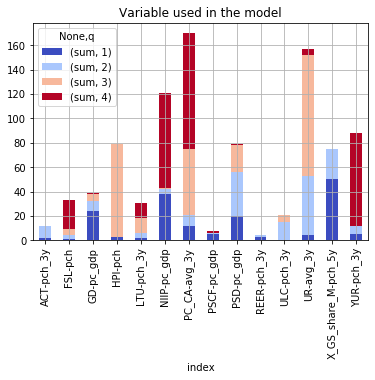

In [15]:
df_testing_bin.reset_index().groupby(["index", "q"])[["sum"]].sum().unstack().plot(kind='bar', stacked=True, title="Variable used in the model", grid=True,cmap="coolwarm")#.sum(axis=1).to_frame()

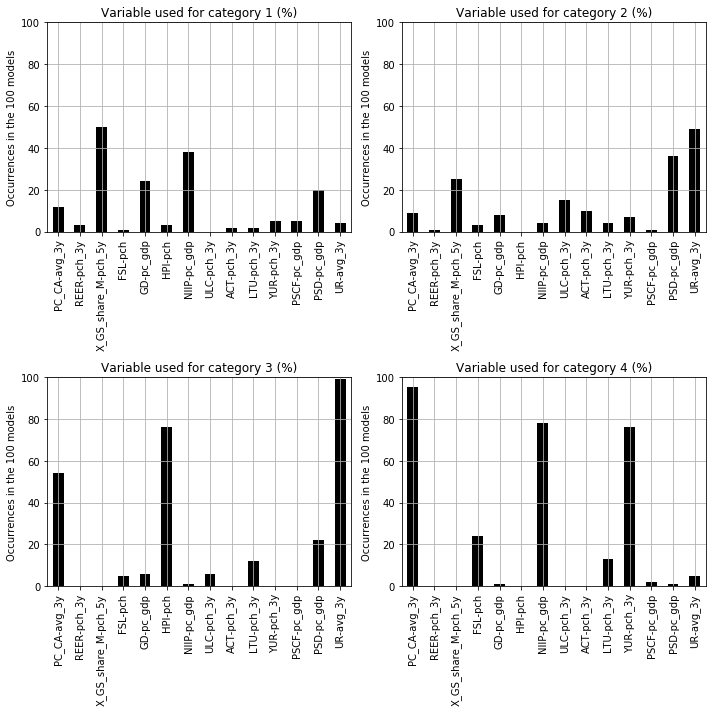

In [16]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10)); axes = axes.flatten()
for i in range(4):  
    df_testing_bin.loc[df_testing_bin.q==str(i+1), "sum"].plot.bar(ax=axes[i], color="k", title="Variable used for category {} (%)".format(i+1))
    axes[i].grid(); axes[i].set_ylim(0,100); axes[i].set_ylabel("Occurrences in the 100 models")
plt.tight_layout()

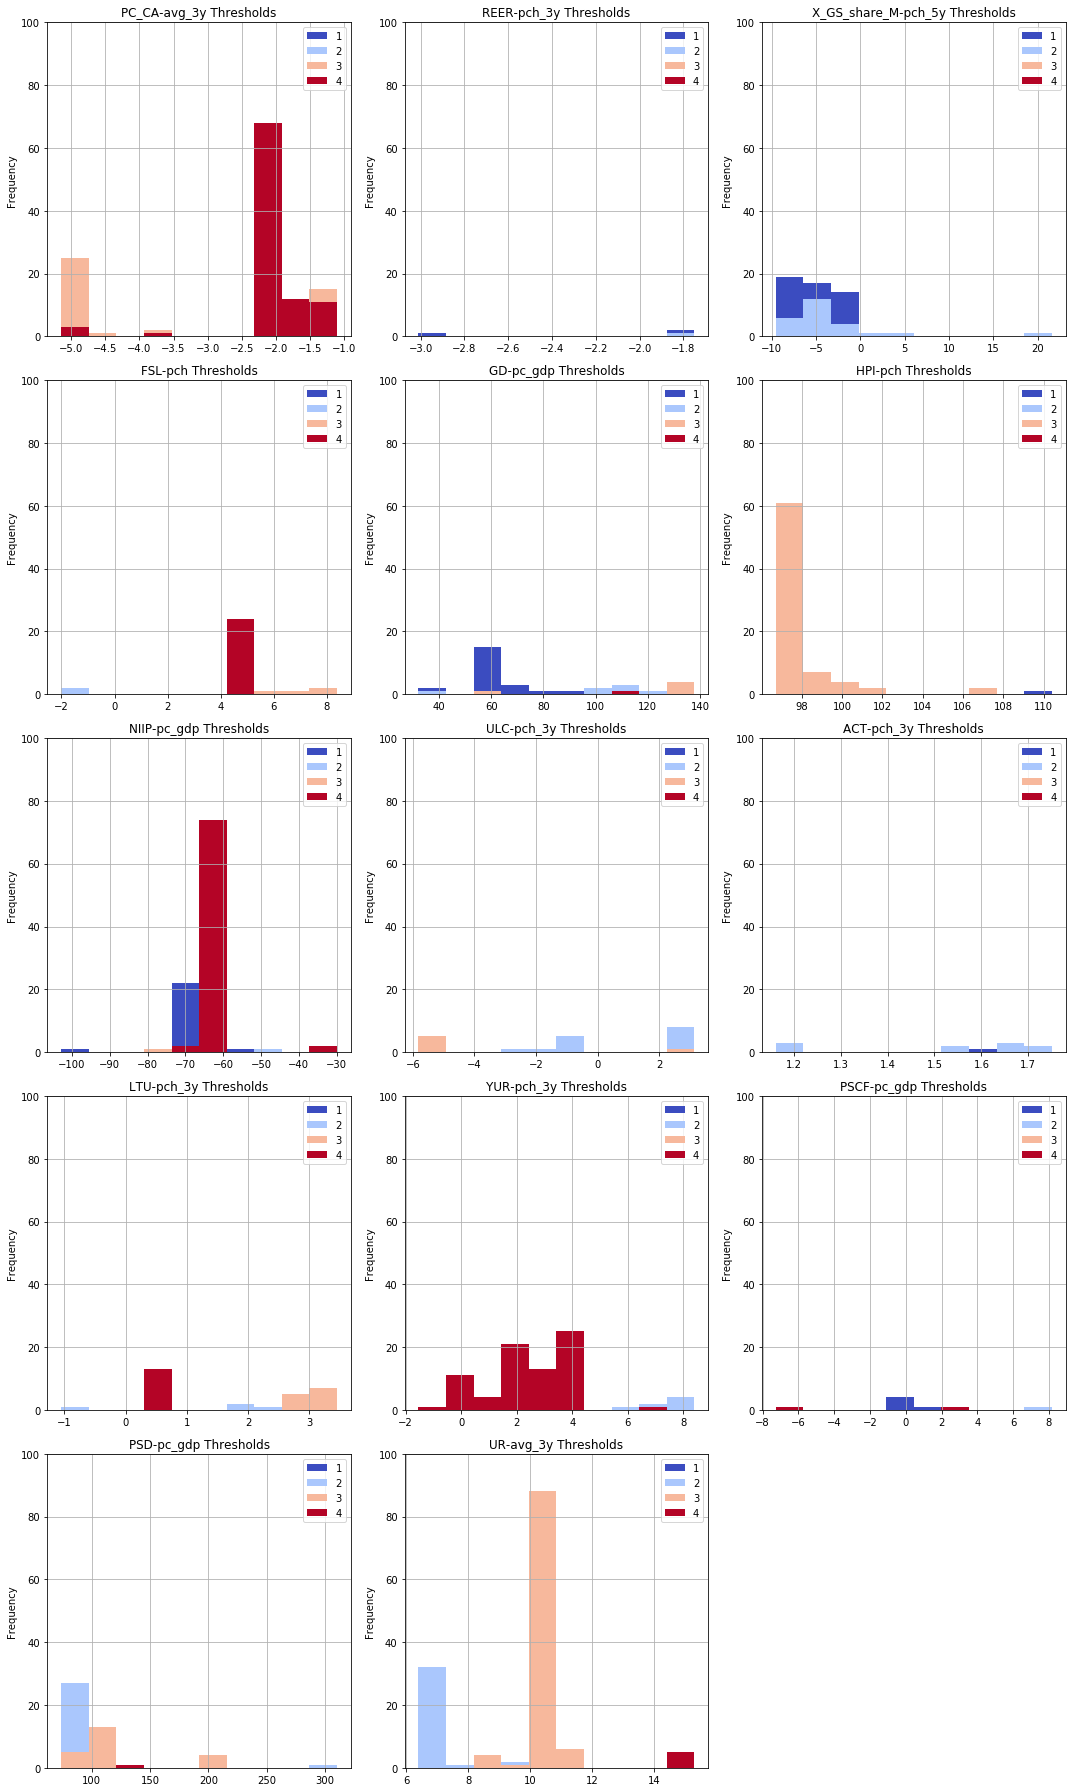

In [17]:
f, axes = plt.subplots(ncols=3, nrows=5, figsize=(15,25)); axes = axes.flatten(); [plt.delaxes(axes[i]) for i in [14]]
for j, col in enumerate(list_cols): 
    pd.DataFrame(df_testing.loc[:,["{}_{}".format(i+1,col) for i in range(4)]].astype(float).values,columns=range(1,5)).plot.hist(ax=axes[j], title="{} Thresholds".format(col),cmap="coolwarm")
    axes[j].set_ylim(0,100)
    axes[j].grid()
plt.tight_layout()

# Model Specific: selecting using the best adj accuracy in the train w/ fabricated

### Country analysis

In the dataset

In [18]:
df_model            = dataset.copy()
df_model['pred']    = dataset.apply(lambda row: get_pred(row, "../aux/processed/", "-{}".format(int_model)), axis=1)
df_model['l==p']    = df_model.pred == df_model.label
df_model['train']   = df_model.index.isin(list_original)
df_model['test']    = ~df_model.index.isin(list_original)
df_model['country'] = df_model.index.str[-2:]
df_model['year']    = df_model.index.str[:4].astype(int)
df_model['split']   = 'train'
df_model.loc[df_model['test'],'split'] = 'test'

In [38]:
df_model.head()

label  PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y  FSL-pch  \
2011_AT      1           2.4         -1.8               -12.46      1.5   
2011_BE      2          -0.1         -1.5                -7.63      5.4   
2011_CZ      1          -2.6         -0.5                 7.43      4.3   
2011_DE      1           5.9         -4.9                -9.31      2.9   
2011_DK      2           5.5         -2.5               -13.74      1.6   

         GD-pc_gdp  HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  ...  \
2011_AT       82.4    88.41         -1.9         5.8         0.7  ...   
2011_BE      102.6    99.49         60.9         5.3        -0.4  ...   
2011_CZ       39.8    98.86        -45.2         3.4         0.8  ...   
2011_DE       79.4    90.32         23.2         5.4         1.4  ...   
2011_DK       46.1    92.83         27.8         3.6        -1.4  ...   

         PSCF-pc_gdp  PSD-pc_gdp  UR-avg_3y  pred  l==p  train   test  \
2011_AT          3.0       129.4        4.9     1  True  False   True   
2011_BE         21.7       181.5        7.8     2  True  False   True   
2011_CZ          2.1        68.3        6.9     1  True   True  False   
2011_DE          1.6       102.9        6.8     1  True   True  False   
2011_DK          4.4       221.0        7.0     2  True  False   True   

         country  year  split  
2011_AT       AT  2011   test  
2011_BE       BE  2011   test  
2011_CZ       CZ  2011  train  
2011_DE       DE  2011  train  
2011_DK       DK  2011   test  

[5 rows x 22 columns]

In [20]:
df_country_dist = pd.DataFrame({
    'dataset':dataset.index.str[-2:].value_counts().sort_index(),
    'train':pd.Series([i[-2:] for i in list_original[list_original!='new']]).value_counts().sort_index(),
    'test':dataset.index[~dataset.index.isin(list_original)].str[-2:].value_counts().sort_index()}).fillna(0).astype(int)

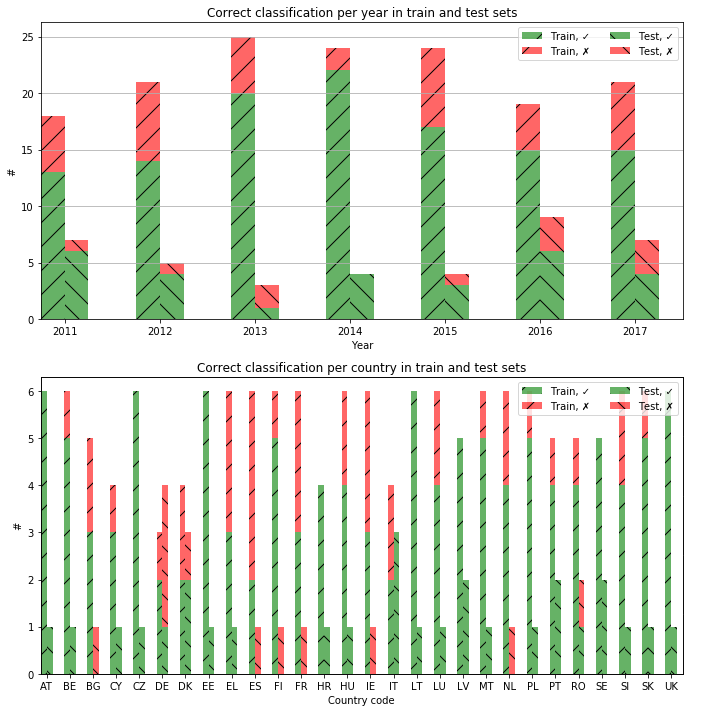

In [76]:
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,10)); axes=axes.flatten(); f.patch.set_facecolor('white')
##1
df_cw=df_model.groupby(['split', 'year'])['l==p'].agg(['count', 'sum']).astype(int)
df_cw.columns=['total', 'correct']; df_cw['wrong']=df_cw.total-df_cw.correct
#ax2 = axes[0].twinx()
df_cw[['correct', 'wrong']].loc["train"].astype(int).plot.bar(stacked=True,ax=axes[0], position=1, width=0.25,alpha=0.6, color=["g","r"], hatch='/')
df_cw[['correct', 'wrong']].loc["test"].astype(int).plot.bar(stacked=True,ax=axes[0], position=0, width=0.25,alpha=0.6, color=["g","r"], hatch='\\')
axes[0].tick_params(axis='x', labelrotation=0)
axes[0].legend(["Train, ✓", 'Train, ✗', "Test, ✓", 'Test, ✗'], loc='best', ncol=2); axes[0].set_xlabel("Year"); axes[0].set_ylabel("#")
axes[0].set_title("Correct classification per year in train and test sets")
axes[0].set_xticklabels(df_cw[['correct', 'wrong']].loc["test"].astype(int).index.values,color='k')
ax2.tick_params(axis='y', colors='white'); axes[0].grid(axis='y')
plt.tight_layout()

##2

df_cw=df_model.groupby(['split', 'country'])['l==p'].agg(['count', 'sum']).astype(int)
df_cw.columns=['total', 'correct']; df_cw['wrong']=df_cw.total-df_cw.correct
ax2 = axes[1].twinx()
df_cw[['correct', 'wrong']].loc["train"].astype(int).plot.bar(stacked=True,ax=axes[1], position=1, width=0.25,alpha=0.6, color=["g","r"], hatch='/')
pd.concat([df_cw.loc["test"],\
           pd.Series({i:0 for i in dataset.index.str[-2:].unique()[~dataset.index.str[-2:].unique().isin(df_cw.loc["test"].index)]})], names=False)\
[['correct', 'wrong']].fillna(0).astype(int).sort_index().plot.bar(stacked=True,ax=axes[1], position=0, width=0.25,alpha=0.6, color=["g","r"], hatch='\\')
axes[1].tick_params(axis='x', labelrotation=0)
axes[1].legend(["Train, ✓", 'Train, ✗', "Test, ✓", 'Test, ✗'], loc='best', ncol=2); axes[1].set_xlabel("Country code"); axes[1].set_ylabel("#")
axes[1].set_title("Correct classification per country in train and test sets")
ax2.tick_params(axis='y', colors='white')
plt.tight_layout()

### Classificaon report

In [22]:
df_testing.loc[[int_model]]

#q 1_PC_CA-avg_3y 1_REER-pch_3y 1_X_GS_share_M-pch_5y 1_FSL-pch  \
32   5            NaN           NaN                   NaN       NaN   

   1_GD-pc_gdp 1_HPI-pch 1_NIIP-pc_gdp 1_ULC-pch_3y 1_ACT-pch_3y  ...  \
32         NaN       NaN           NaN          NaN          NaN  ...   

   4_UR-avg_3y accuracy_test accuracy_train accuracy_train_adj f1_test_micro  \
32         NaN      0.758767       0.813187           0.768778      0.717949   

   f1_test_macro f1_test_weighted f1_train_adj_micro f1_train_adj_macro  \
32      0.737401         0.707381           0.763158           0.739424   

   f1_train_adj_weighted  
32               0.76063  

[1 rows x 66 columns]

In [23]:
df_model_rules=pd.DataFrame(open("../aux/processed/{}-{}".format(file_type,int_model), 'r').read().split("\n")[:-1] for file_type in ['model_conditions', "model_pred"]).T
df_model_rules.columns=["Thresholds", 'Category']

In [24]:
df_model_rules

Thresholds Category
0  PC_CA.avg_3y<=-2.098 & NIIP.pc_gdp<=-66.078 & LTU.pch_3y...        4
1           HPI.pch>97.687 & PSD.pc_gdp>98.05 & UR.avg_3y>8.99        3
2     YUR.pch_3y<=2.929 & PSCF.pc_gdp>0.27 & PSD.pc_gdp<=136.7        1
3               X_GS_share_M.pch_5y<=-3.53 & GD.pc_gdp<=107.88        2
4                                                         Else        1

In [25]:
print(classification_report(y_true=df_model.loc[df_model.train].label, y_pred=df_model.loc[df_model.train].pred))

              precision    recall  f1-score   support

           1       0.83      0.87      0.85        68
           2       0.79      0.59      0.67        51
           3       0.59      0.85      0.69        20
           4       0.71      0.77      0.74        13

    accuracy                           0.76       152
   macro avg       0.73      0.77      0.74       152
weighted avg       0.77      0.76      0.76       152



In [26]:
print(classification_report(y_true=test.label, y_pred=test.apply(lambda row: get_pred(row, "../aux/processed/", "-{}".format(int_model)), axis=1)))

              precision    recall  f1-score   support

           1       0.74      0.82      0.78        17
           2       0.67      0.46      0.55        13
           3       0.62      1.00      0.77         5
           4       1.00      0.75      0.86         4

    accuracy                           0.72        39
   macro avg       0.76      0.76      0.74        39
weighted avg       0.73      0.72      0.71        39



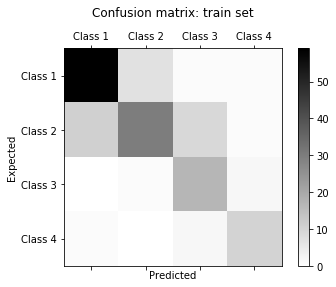

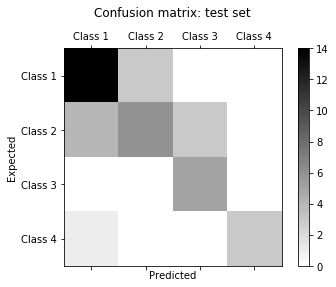

In [36]:
conf_mat = confusion_matrix(y_true=df_model.loc[df_model.train].label, y_pred=df_model.loc[df_model.train].pred)
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.binary)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title("Confusion matrix: train set\n")
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

conf_mat = confusion_matrix(y_true=df_model.loc[df_model.test].label, y_pred=df_model.loc[df_model.test].pred)
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.binary)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title("Confusion matrix: test set\n")
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()